# Text classification with CNN and RNN

We apply CNN and RNN to IMDB database, which includes 50,000 movie reviews, to do text classification. We construct different CNN and RNN structures, even we explore mix CNN-RNN model.Then all these results are compared to classical machine learning algorithms, naive bayes and SVM. we explore the influence of overfitting and regularization. 

## Import database


In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [3]:
word_index=imdb.get_word_index()

In [4]:
# # Convert .bin to .txt, read only 300000 top words

# from gensim.models.keyedvectors import KeyedVectors

# convert = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True,limit=300000)
# convert.save_word2vec_format('GoogleNews-vectors-negative300.txt', binary=False)

Every interger represents one words in the vocabulary.

**Transfer integer to words**

In [5]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
def save_history(history,model_name):
   #history: fit history
   # model_name:String, to generate a csv file to save the history
    import pandas as pd
    history_crnn=pd.DataFrame({'acc_train':history.history["acc"],'acc_val':history.history["val_acc"],
                                       'loss_train':history.history["loss"],'loss_val':history.history["val_loss"]
                         
                          })
    history_crnn.to_csv(model_name+'.csv')

## Data preprocessing

* pad the every sentence to uniform length
* use pre_trained glove data to represent the sentences


In [6]:
#model_list includes every models and how to generate embedding layer
import model_list

Using TensorFlow backend.


In [7]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [8]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [9]:
vocab_size=10000
embedding_size=300
max_length=256

In [10]:
#get embedding layer, default is use golve representation
embedding_layer=model_list.get_embedding_layer(word_index,USE_PRE=0,vocab_size=10000,embedding_size=300,max_length=256)

## CNN part

### Text CNN
[Reference Blog](http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/)

[Reference Paper](https://arxiv.org/abs/1408.5882)

In [11]:
text_cnn_model=model_list.text_cnn(embedding_layer)

In [12]:
print(text_cnn_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 256, 300)     3000000     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 256, 256)     230656      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 256, 256)     307456      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (

In [13]:
history_text_cnn = text_cnn_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 29s 2ms/step - loss: 0.5807 - acc: 0.6615 - val_loss: 0.3356 - val_acc: 0.8600
Epoch 2/20
15000/15000 [==============================] - 19s 1ms/step - loss: 0.2343 - acc: 0.9078 - val_loss: 0.2877 - val_acc: 0.8842
Epoch 3/20
15000/15000 [==============================] - 20s 1ms/step - loss: 0.1039 - acc: 0.9662 - val_loss: 0.3524 - val_acc: 0.8790
Epoch 4/20
15000/15000 [==============================] - 19s 1ms/step - loss: 0.0476 - acc: 0.9874 - val_loss: 0.4446 - val_acc: 0.8741
Epoch 5/20
15000/15000 [==============================] - 20s 1ms/step - loss: 0.0202 - acc: 0.9968 - val_loss: 0.5442 - val_acc: 0.8673
Epoch 6/20
15000/15000 [==============================] - 20s 1ms/step - loss: 0.0070 - acc: 0.9995 - val_loss: 0.6172 - val_acc: 0.8655
Epoch 7/20
15000/15000 [==============================] - 20s 1ms/step - loss: 0.0029 - acc: 0.9999 - val_loss: 0.6662 - val_acc

In [14]:
save_history(history_text_cnn,'history_text_cnn'+'')

In [15]:
loss_,accuracy_=text_cnn_model.evaluate(test_data,test_labels)
print('The loss on validation set is %f, accuracy is %f'%(loss_,accuracy_))

25000/25000 [==============================] - 11s 427us/step
The loss on validation set is 0.987454, accuracy is 0.851000


### Channel CNN

In [16]:
filter_sizes=[3,4,5]
feature_maps    = [100,100,100]
hidden_units=100
dropout_rate=.3

In [17]:
channel_cnn_model=model_list.Channel_cnn(embedding_layer,filter_sizes,feature_maps)

In [18]:
print(channel_cnn_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_input (InputLayer)         (None, 256)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 256, 300)     3000000     word_input[0][0]                 
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 300)     0           embedding_1[1][0]                
__________________________________________________________________________________________________
separable_conv1d_1 (SeparableCo (None, 256, 100)     123700      dropout_2[0][0]                  
__________________________________________________________________________________________________
separable_

In [19]:
history_channel_cnn = channel_cnn_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 32s 2ms/step - loss: 0.4957 - acc: 0.7923 - val_loss: 0.3862 - val_acc: 0.8325
Epoch 2/20
15000/15000 [==============================] - 30s 2ms/step - loss: 0.2497 - acc: 0.9002 - val_loss: 0.3679 - val_acc: 0.8500
Epoch 3/20
15000/15000 [==============================] - 31s 2ms/step - loss: 0.1480 - acc: 0.9490 - val_loss: 0.4177 - val_acc: 0.8488
Epoch 4/20
15000/15000 [==============================] - 31s 2ms/step - loss: 0.0840 - acc: 0.9737 - val_loss: 0.4946 - val_acc: 0.8425
Epoch 5/20
15000/15000 [==============================] - 30s 2ms/step - loss: 0.0411 - acc: 0.9892 - val_loss: 0.5925 - val_acc: 0.8379
Epoch 6/20
15000/15000 [==============================] - 31s 2ms/step - loss: 0.0189 - acc: 0.9954 - val_loss: 0.6735 - val_acc: 0.8418
Epoch 7/20
15000/15000 [==============================] - 31s 2ms/step - loss: 0.0092 - acc: 0.9983 - val_loss: 0.7302 - val_acc

In [20]:
save_history(history_channel_cnn,'history_channel_cnn'+'' )

In [21]:
loss_,accuracy_=channel_cnn_model.evaluate(test_data,test_labels)
print('The loss on validation set is %f, accuracy is %f'%(loss_,accuracy_))

25000/25000 [==============================] - 12s 469us/step
The loss on validation set is 1.198058, accuracy is 0.821520


## LSTM

[Understanding LSTM Network](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)


In [22]:
LSTM_model=model_list.single_LSTM(embedding_layer,cell_num=100,dropout_rate=0.2,recurrent_dropout_rate=0.1)

In [23]:
print(LSTM_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 300)          3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 3,160,501
Trainable params: 3,160,501
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
history_LSTM_model = LSTM_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 49s 3ms/step - loss: 0.4941 - acc: 0.7530 - val_loss: 0.4716 - val_acc: 0.8263
Epoch 2/20
15000/15000 [==============================] - 42s 3ms/step - loss: 0.3604 - acc: 0.8821 - val_loss: 0.4321 - val_acc: 0.8462
Epoch 3/20
15000/15000 [==============================] - 45s 3ms/step - loss: 0.3477 - acc: 0.8881 - val_loss: 0.4081 - val_acc: 0.8514
Epoch 4/20
15000/15000 [==============================] - 43s 3ms/step - loss: 0.6277 - acc: 0.6913 - val_loss: 0.6159 - val_acc: 0.6811
Epoch 5/20
15000/15000 [==============================] - 43s 3ms/step - loss: 0.5102 - acc: 0.7699 - val_loss: 0.5258 - val_acc: 0.7851
Epoch 6/20
15000/15000 [==============================] - 44s 3ms/step - loss: 0.4290 - acc: 0.8414 - val_loss: 0.5415 - val_acc: 0.7696
Epoch 7/20
15000/15000 [==============================] - 42s 3ms/step - loss: 0.4557 - acc: 0.8210 - val_loss: 0.4989 - val_acc

In [25]:
save_history(history_LSTM_model,'history_LSTM_model'+'' )

In [26]:
loss_,accuracy_=LSTM_model.evaluate(test_data,test_labels)
print('The loss on validation set is %f, accuracy is %f'%(loss_,accuracy_))

25000/25000 [==============================] - 147s 6ms/step
The loss on validation set is 0.392373, accuracy is 0.855360


## Bi-GRU (take a long time)
[Recurrent Neural Network for Text Classification with Multi-Task Learning](https://www.ijcai.org/Proceedings/16/Papers/408.pdf)

In [27]:
# Bi_GRU_model=model_list.Bi_GRU(embedding_layer,cell_num=128,dropout_rate=0.2,recurrent_dropout_rate=0.1)

In [28]:
# print(Bi_GRU_model.summary())

In [29]:
# history_Bi_GRU_model = Bi_GRU_model.fit(partial_x_train,
#                     partial_y_train,
#                     epochs=6,
#                     batch_size=256,
#                     validation_data=(x_val, y_val),
#                     verbose=1)

In [30]:
# save_history(history_Bi_GRU_model,'history_Bi_GRU_model' )

## C_GRU_Series

[A C-LSTM Neural Network for Text Classification](https://arxiv.org/abs/1511.08630)

In [31]:
C_GRU_series_model=model_list.C_RNN_series(embedding_layer)

In [32]:
print(C_GRU_series_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 300)          3000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 256, 128)          115328    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 128, 128)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128, 128)          98688     
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 3,312,833
Trainable params: 3,312,833
Non-trainable params: 0
_________________________________________________________________


In [33]:
history_C_GRU_series_model= C_GRU_series_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 39s 3ms/step - loss: 0.4535 - acc: 0.7481 - val_loss: 0.4357 - val_acc: 0.8424
Epoch 2/20
15000/15000 [==============================] - 37s 2ms/step - loss: 0.3039 - acc: 0.8943 - val_loss: 0.4471 - val_acc: 0.8330
Epoch 3/20
15000/15000 [==============================] - 38s 3ms/step - loss: 0.6374 - acc: 0.6467 - val_loss: 0.6597 - val_acc: 0.5831
Epoch 4/20
15000/15000 [==============================] - 37s 2ms/step - loss: 0.5129 - acc: 0.8001 - val_loss: 0.3723 - val_acc: 0.8487
Epoch 5/20
15000/15000 [==============================] - 38s 3ms/step - loss: 0.2143 - acc: 0.9187 - val_loss: 0.3910 - val_acc: 0.8530
Epoch 6/20
15000/15000 [==============================] - 38s 3ms/step - loss: 0.1389 - acc: 0.9496 - val_loss: 0.3880 - val_acc: 0.8646
Epoch 7/20
15000/15000 [==============================] - 38s 3ms/step - loss: 0.0949 - acc: 0.9690 - val_loss: 0.4227 - val_acc

In [34]:
save_history(history_C_GRU_series_model,'history_C_GRU_series_model'+'' )

In [35]:
loss_,accuracy_=C_GRU_series_model.evaluate(test_data,test_labels)
print('The loss on validation set is %f, accuracy is %f'%(loss_,accuracy_))

25000/25000 [==============================] - 129s 5ms/step
The loss on validation set is 0.913046, accuracy is 0.832520


## C_GRU_Parallel 

No reference paper

In [36]:
C_RNN_Parallel_model=model_list.C_RNN_Parallel(embedding_layer)

In [37]:
print(C_RNN_Parallel_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 256, 300)     3000000     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 256, 256)     230656      embedding_1[4][0]                
__________________________________________________________________________________________________
max_pooling1d_5 (MaxPooling1D)  (None, 64, 256)      0           conv1d_5[0][0]                   
__________________________________________________________________________________________________
flatten_2 

In [38]:
history_C_RNN_Parallel_model= C_RNN_Parallel_model.fit(partial_x_train,#very slow
                    partial_y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 93s 6ms/step - loss: 0.2689 - acc: 0.8868 - val_loss: 0.4781 - val_acc: 0.8711
Epoch 2/20
15000/15000 [==============================] - 93s 6ms/step - loss: 0.0401 - acc: 0.9884 - val_loss: 0.6004 - val_acc: 0.8656
Epoch 3/20
15000/15000 [==============================] - 93s 6ms/step - loss: 0.0152 - acc: 0.9980 - val_loss: 0.7505 - val_acc: 0.8653
Epoch 4/20
15000/15000 [==============================] - 94s 6ms/step - loss: 0.0057 - acc: 0.9994 - val_loss: 0.8476 - val_acc: 0.8661
Epoch 5/20
15000/15000 [==============================] - 93s 6ms/step - loss: 0.0025 - acc: 0.9998 - val_loss: 0.9177 - val_acc: 0.8662
Epoch 6/20
15000/15000 [==============================] - 94s 6ms/step - loss: 0.0018 - acc: 0.9999 - val_loss: 0.9420 - val_acc: 0.8665
Epoch 7/20
15000/15000 [==============================] - 94s 6ms/step - loss: 0.0016 - acc: 0.9999 - val_loss: 0.9863 - val_acc

In [39]:
save_history(history_C_RNN_Parallel_model,'history_C_RNN_Parallel_model'+'' )

In [40]:
loss_,accuracy_=C_RNN_Parallel_model.evaluate(test_data,test_labels)
print('The loss on validation set is %f, accuracy is %f'%(loss_,accuracy_))

25000/25000 [==============================] - 197s 8ms/step
The loss on validation set is 1.343742, accuracy is 0.846360


## Visulization

In [41]:
#matplotlib inline
import matplotlib.pyplot as plt

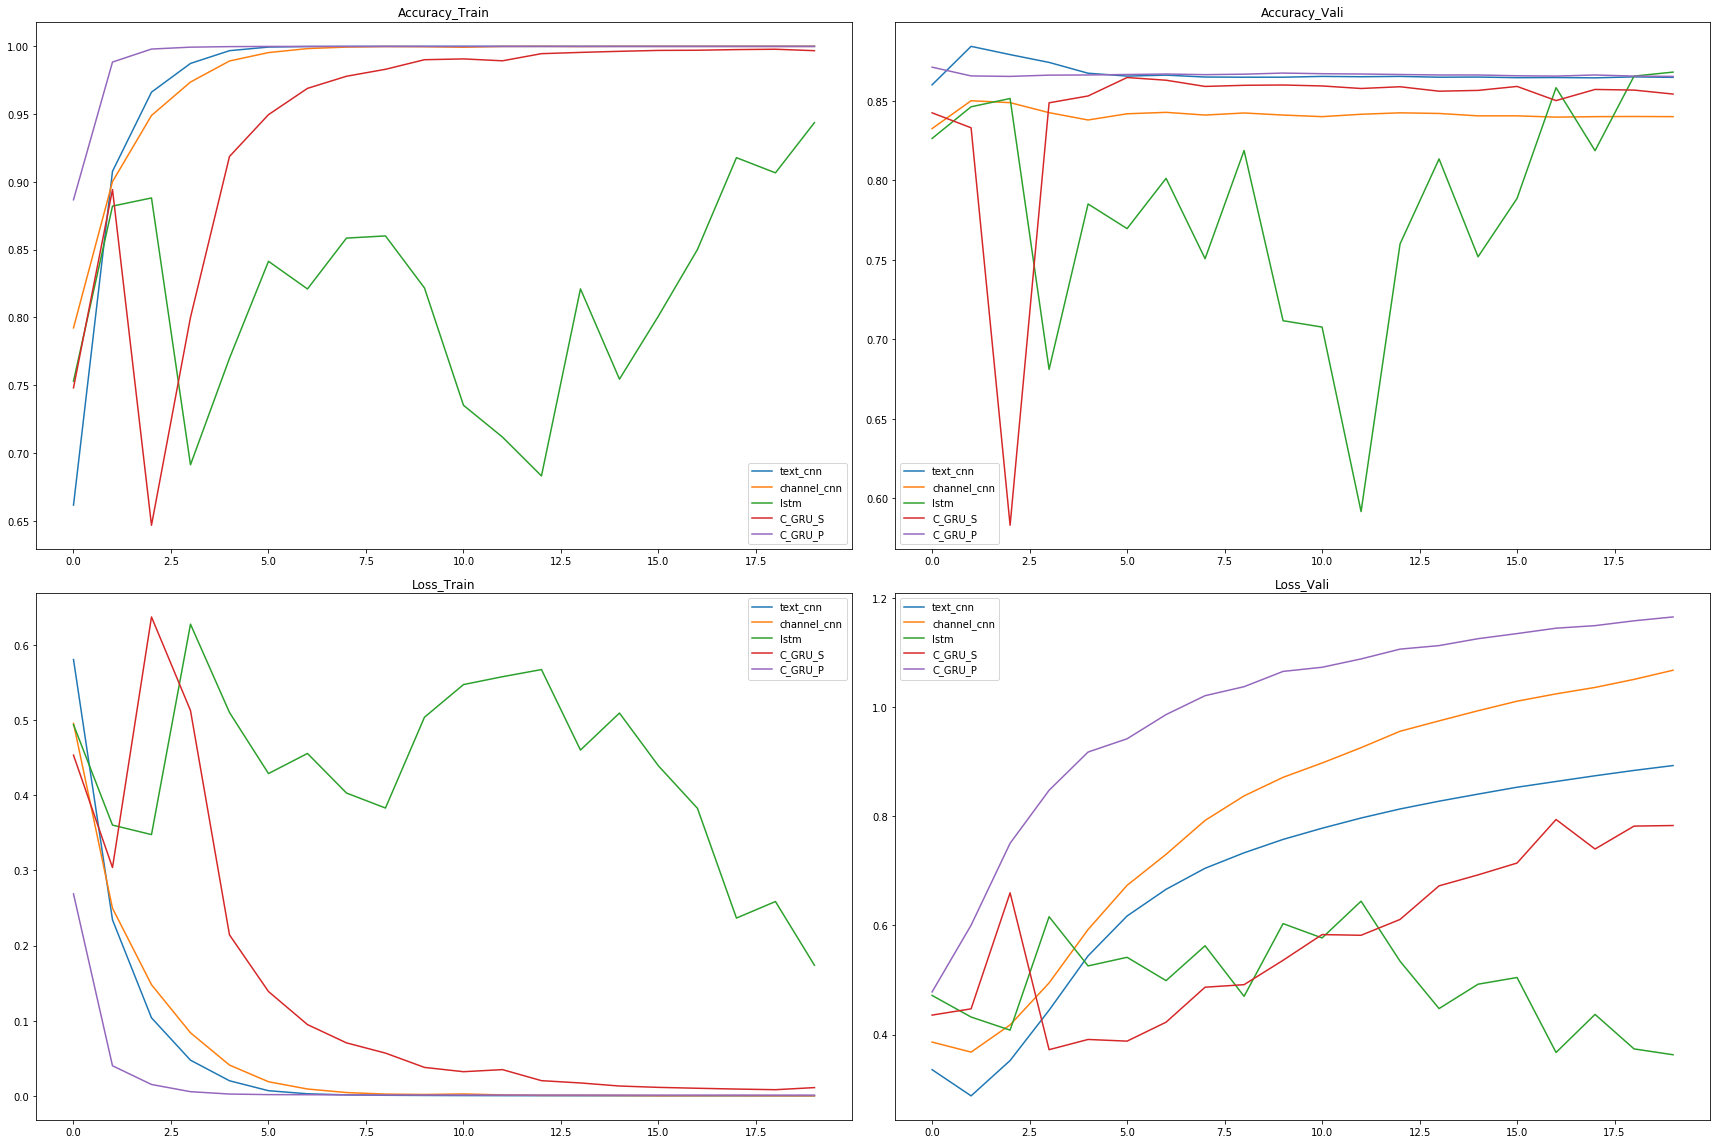

In [42]:
plt.figure(figsize=[24,16]) 
plt.subplot(221)
plt.title('Accuracy_Train')
plt.plot(history_text_cnn.history['acc'],label='text_cnn')
plt.plot(history_channel_cnn.history['acc'],label='channel_cnn')
# plt.plot(history_Bi_GRU_model.history['acc'],label='Bi_GRU')
plt.plot(history_LSTM_model.history['acc'],label='lstm')
plt.plot(history_C_GRU_series_model.history['acc'],label='C_GRU_S')
plt.plot(history_C_RNN_Parallel_model.history['acc'],label='C_GRU_P')
plt.legend(loc='best')

plt.subplot(222)
plt.title('Accuracy_Vali')
plt.plot(history_text_cnn.history['val_acc'],label='text_cnn')
plt.plot(history_channel_cnn.history['val_acc'],label='channel_cnn')
# plt.plot(history_Bi_GRU_model.history['val_acc'],label='Bi_GRU')
plt.plot(history_LSTM_model.history['val_acc'],label='lstm')
plt.plot(history_C_GRU_series_model.history['val_acc'],label='C_GRU_S')
plt.plot(history_C_RNN_Parallel_model.history['val_acc'],label='C_GRU_P')
plt.legend(loc='best')

plt.subplot(223)
plt.title('Loss_Train')
plt.plot(history_text_cnn.history['loss'],label='text_cnn')
plt.plot(history_channel_cnn.history['loss'],label='channel_cnn')
# plt.plot(history_Bi_GRU_model.history['loss'],label='Bi_GRU')
plt.plot(history_LSTM_model.history['loss'],label='lstm')
plt.plot(history_C_GRU_series_model.history['loss'],label='C_GRU_S')
plt.plot(history_C_RNN_Parallel_model.history['loss'],label='C_GRU_P')
plt.legend(loc='best')

plt.subplot(224)
plt.title('Loss_Vali')
plt.plot(history_text_cnn.history['val_loss'],label='text_cnn')
plt.plot(history_channel_cnn.history['val_loss'],label='channel_cnn')
# plt.plot(history_Bi_GRU_model.history['val_loss'],label='Bi_GRU')
plt.plot(history_LSTM_model.history['val_loss'],label='lstm')
plt.plot(history_C_GRU_series_model.history['val_loss'],label='C_GRU_S')
plt.plot(history_C_RNN_Parallel_model.history['val_loss'],label='C_GRU_P')
plt.legend(loc='best')
plt.savefig('all_models'+'')
plt.tight_layout()
plt.show()


## regularization

### regularizer.l2

In [43]:
C_RNN_Parallel_model_reg=model_list.C_RNN_Parallel2(embedding_layer,reg_coef=0.01)

In [44]:
print(C_RNN_Parallel_model_reg.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 256, 300)     3000000     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 256, 256)     230656      embedding_1[5][0]                
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 256, 256)     0           conv1d_6[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [45]:
history_C_RNN_Parallel_model_reg= C_RNN_Parallel_model_reg.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 100s 7ms/step - loss: 1.6412 - acc: 0.8919 - val_loss: 0.8619 - val_acc: 0.8671
Epoch 2/20
15000/15000 [==============================] - 99s 7ms/step - loss: 0.2464 - acc: 0.9945 - val_loss: 0.5542 - val_acc: 0.8674
Epoch 3/20
15000/15000 [==============================] - 99s 7ms/step - loss: 0.0684 - acc: 0.9985 - val_loss: 0.5467 - val_acc: 0.8691
Epoch 4/20
15000/15000 [==============================] - 102s 7ms/step - loss: 0.0313 - acc: 0.9995 - val_loss: 0.5665 - val_acc: 0.8670
Epoch 5/20
15000/15000 [==============================] - 97s 6ms/step - loss: 0.0211 - acc: 0.9997 - val_loss: 0.6061 - val_acc: 0.8686
Epoch 6/20
15000/15000 [==============================] - 97s 6ms/step - loss: 0.0190 - acc: 0.9995 - val_loss: 0.6725 - val_acc: 0.8661
Epoch 7/20
15000/15000 [==============================] - 99s 7ms/step - loss: 0.0156 - acc: 0.9993 - val_loss: 0.7808 - val_a

In [46]:
save_history(history_C_RNN_Parallel_model_reg,'history_C_RNN_Parallel_model_reg'+'' )

In [47]:
loss_,accuracy_=C_RNN_Parallel_model_reg.evaluate(test_data,test_labels)
print('The loss on validation set is %f, accuracy is %f'%(loss_,accuracy_))

25000/25000 [==============================] - 183s 7ms/step
The loss on validation set is 0.968073, accuracy is 0.835040


### dropout

In [48]:
C_RNN_Parallel_model_dropout=model_list.C_RNN_Parallel2(embedding_layer,dropout_rate_conv=0.4)

In [49]:
print(C_RNN_Parallel_model_dropout.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 256, 300)     3000000     input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 256, 256)     230656      embedding_1[6][0]                
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 256, 256)     0           conv1d_7[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [50]:
history_C_RNN_Parallel_model_dropout= C_RNN_Parallel_model_dropout.fit(partial_x_train,#very slow
                    partial_y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 101s 7ms/step - loss: 0.2245 - acc: 0.9161 - val_loss: 0.5720 - val_acc: 0.8637
Epoch 2/20
15000/15000 [==============================] - 102s 7ms/step - loss: 0.0061 - acc: 0.9995 - val_loss: 0.7306 - val_acc: 0.8603
Epoch 3/20
15000/15000 [==============================] - 103s 7ms/step - loss: 0.0020 - acc: 0.9999 - val_loss: 0.8245 - val_acc: 0.8563
Epoch 4/20
15000/15000 [==============================] - 109s 7ms/step - loss: 0.0016 - acc: 0.9999 - val_loss: 0.8329 - val_acc: 0.8589
Epoch 5/20
15000/15000 [==============================] - 101s 7ms/step - loss: 0.0013 - acc: 0.9999 - val_loss: 0.8627 - val_acc: 0.8587
Epoch 6/20
15000/15000 [==============================] - 103s 7ms/step - loss: 0.0012 - acc: 0.9999 - val_loss: 0.9035 - val_acc: 0.8578
Epoch 7/20
15000/15000 [==============================] - 103s 7ms/step - loss: 0.0012 - acc: 0.9999 - val_loss: 0.9474 - 

In [51]:
save_history(history_C_RNN_Parallel_model_dropout,'history_C_RNN_Parallel_model_dropout'+'' )

In [52]:
loss_,accuracy_=C_RNN_Parallel_model_dropout.evaluate(test_data,test_labels)
print('The loss on validation set is %f, accuracy is %f'%(loss_,accuracy_))

25000/25000 [==============================] - 189s 8ms/step
The loss on validation set is 1.253954, accuracy is 0.831920


## Visualization

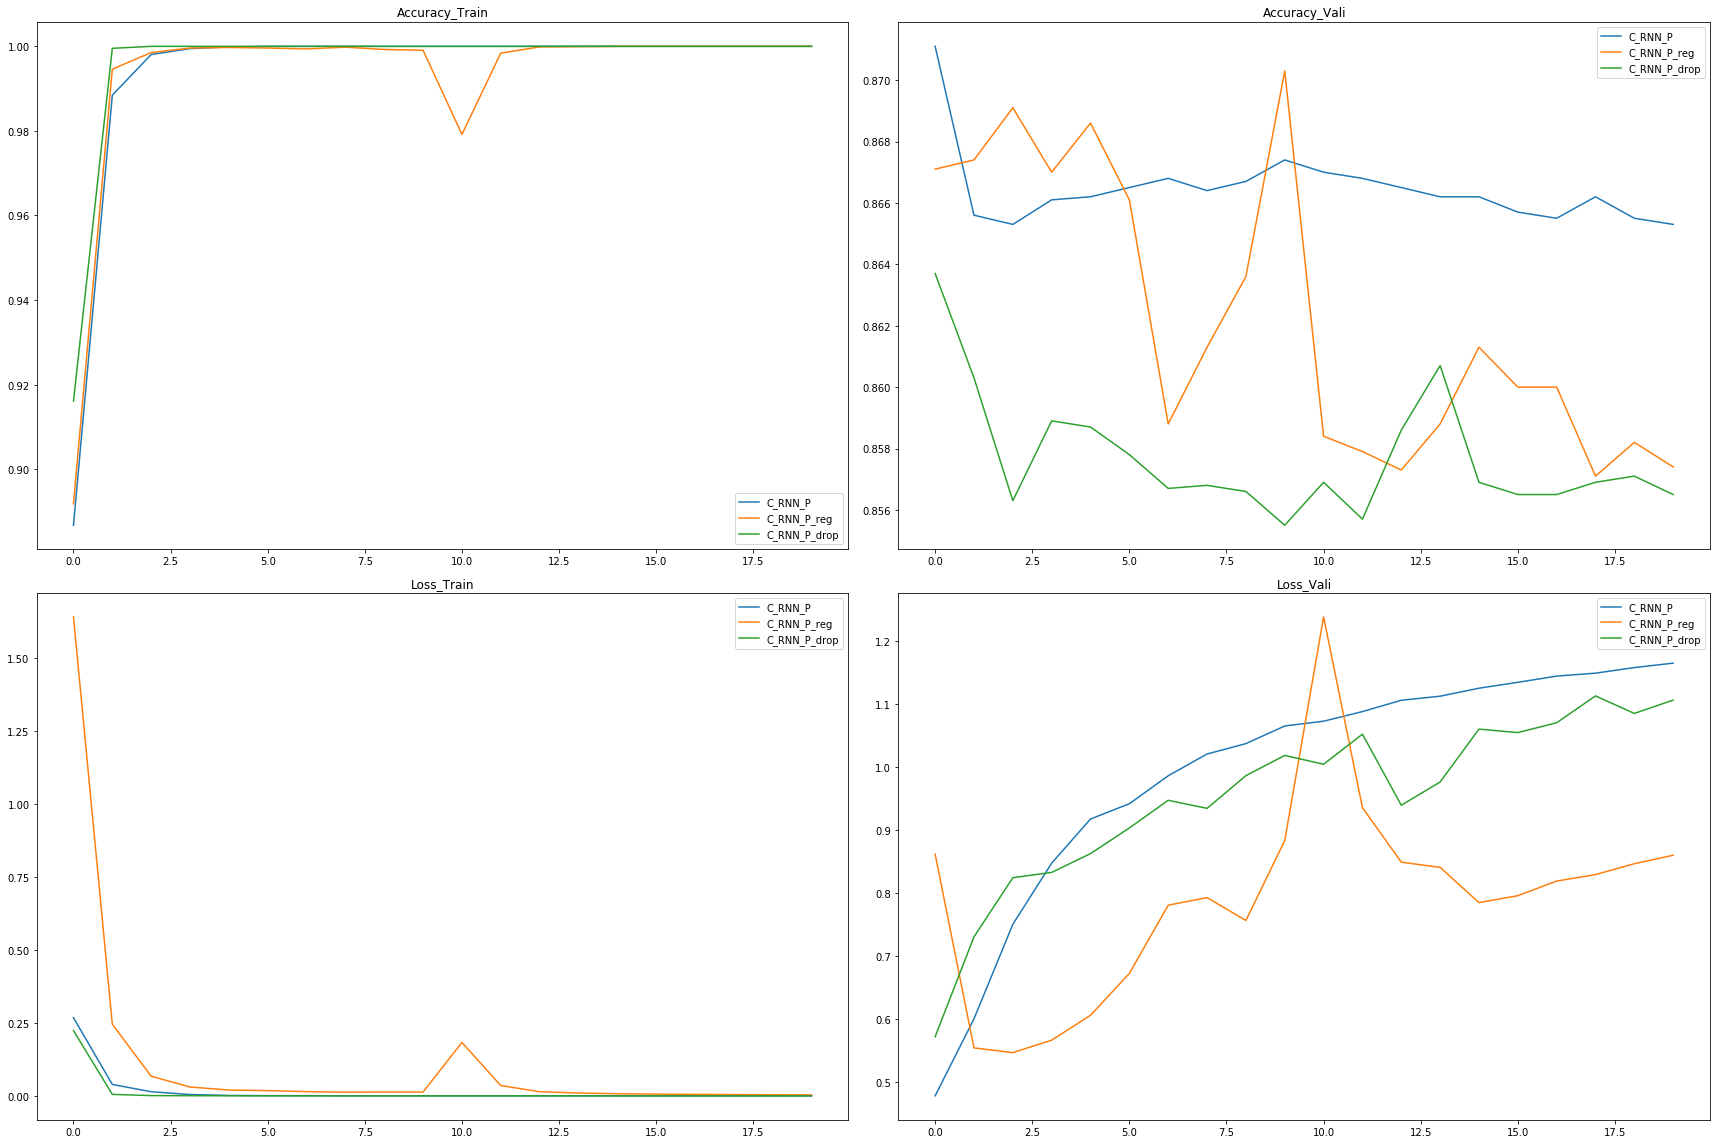

In [53]:
plt.figure(figsize=[24,16])

plt.subplot(221)
plt.title('Accuracy_Train')
plt.plot(history_C_RNN_Parallel_model.history['acc'],label='C_RNN_P')
plt.plot(history_C_RNN_Parallel_model_reg.history['acc'],label='C_RNN_P_reg')
plt.plot(history_C_RNN_Parallel_model_dropout.history['acc'],label='C_RNN_P_drop')
plt.legend(loc='best')

plt.subplot(222)
plt.title('Accuracy_Vali')
plt.plot(history_C_RNN_Parallel_model.history['val_acc'],label='C_RNN_P')
plt.plot(history_C_RNN_Parallel_model_reg.history['val_acc'],label='C_RNN_P_reg')
plt.plot(history_C_RNN_Parallel_model_dropout.history['val_acc'],label='C_RNN_P_drop')
plt.legend(loc='best')

plt.subplot(223)
plt.title('Loss_Train')
plt.plot(history_C_RNN_Parallel_model.history['loss'],label='C_RNN_P')
plt.plot(history_C_RNN_Parallel_model_reg.history['loss'],label='C_RNN_P_reg')
plt.plot(history_C_RNN_Parallel_model_dropout.history['loss'],label='C_RNN_P_drop')
plt.legend(loc='best')

plt.subplot(224)
plt.title('Loss_Vali')
plt.plot(history_C_RNN_Parallel_model.history['val_loss'],label='C_RNN_P')
plt.plot(history_C_RNN_Parallel_model_reg.history['val_loss'],label='C_RNN_P_reg')
plt.plot(history_C_RNN_Parallel_model_dropout.history['val_loss'],label='C_RNN_P_drop')
plt.legend(loc='best')
plt.savefig('reg_and_drop'+''+'.png')
plt.tight_layout()
plt.show()
